In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Rescaling                                                  # type: ignore
from tensorflow.keras.models import Sequential                                                                                   # type: ignore
from tensorflow.keras.callbacks import EarlyStopping                                                                             # type: ignore
import matplotlib.pyplot as plt                                                                                                  
import os
import sys
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:", sys.version)
print("CPU Count:", os.cpu_count())

TensorFlow version: 2.20.0
Keras version: 3.11.3
Python version: 3.11.8 (tags/v3.11.8:db85d51, Feb  6 2024, 22:03:32) [MSC v.1937 64 bit (AMD64)]
CPU Count: 8


In [2]:
train_another_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\train_another'
val_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\validation_another'
test_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\test'
test_another_dir = r'X:\nasim_xhqpjmy\Code\MLops\hurricane-damage\dataset\test_another'

In [3]:
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_another_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
#Augmentation 
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    # optional zoom simulation (light)
    scale = tf.random.uniform([], 0.9, 1.1)
    new_size = tf.cast(tf.convert_to_tensor(img_size, dtype=tf.float32) * scale, tf.int32)
    image = tf.image.resize(image, new_size)
    image = tf.image.resize_with_crop_or_pad(image, img_size[0], img_size[1])
    return image, label

In [5]:
# Apply augmentation only to training set
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds
            .map(augment, num_parallel_calls=AUTOTUNE)
            .cache()
            .shuffle(1000)
            .prefetch(buffer_size=AUTOTUNE))

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
def build_cnn(input_shape=(128, 128, 3)):
    model = Sequential([
        # Normalize & augment 
        Rescaling(1./255, input_shape=input_shape),

        # First conv block
        Conv2D(8, 3, activation='relu', padding='same'),
        MaxPooling2D(),

        #Second conv block 
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPooling2D(),

        # Third conv block — depthwise-separable
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),

        #dense head
        Dense(32, activation='relu'),
        Dropout(0.2),

        #Output
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [7]:
def train_model(train_ds, val_ds, epochs=5):
    model = build_cnn()
    print(model.summary())

    es = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[es],
        verbose=1
    )
    return model, history

In [8]:
model, history = train_model(train_ds, val_ds, epochs=5)

x:\nasim_xhqpjmy\Code\MLops\hurricane-damage\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 32, 32, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,169 (12.38 KB)

 Trainable params: 3,169 (12.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.6052 - loss: 0.6657 - val_accuracy: 0.7405 - val_loss: 0.5858
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7421 - loss: 0.5489 - val_accuracy: 0.7790 - val_loss: 0.5189
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8241 - loss: 0.4363 - val_accuracy: 0.8540 - val_loss: 0.3995
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8485 - loss: 0.3825 - val_accuracy: 0.8570 - val_loss: 0.3967
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8672 - loss: 0.3476 - val_accuracy: 0.8750 - val_loss: 0.3475


In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.8635 - loss: 0.3753
Test Accuracy: 86.35%


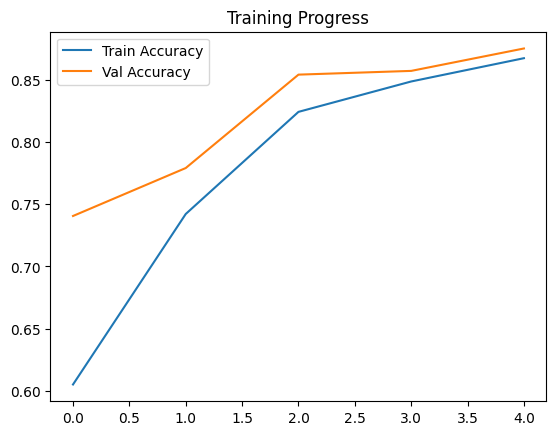

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training Progress")
plt.show()

In [11]:
model.save("hurricane.h5")